In [21]:
import numpy as np
import cv2
import math
import os
import h5py
from tqdm import tqdm
import matplotlib.pyplot as plt
from dask import delayed, compute
from numba import njit, prange

from sklearn import datasets
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

from skimage.transform import integral_image
from skimage.feature import haar_like_feature, haar_like_feature_coord, draw_haar_like_feature, Cascade
from skimage import data

Define the function separately to utilize multiprocess in order to accelerate the calculation

In [2]:
@njit(parallel=True, fastmath=True)
def output_err(x, y):
    n = len(x)
    temp = np.zeros(n)
    for i in range(n):
        if x[i] != y[i]:
            temp[i] = 1
    return temp.mean()

# plot ROC curve
def plot_roc_curve(y_test, predict_score):
    fpr, tpr, thresholds = roc_curve(y_test, predict_score)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, color="darkorange",
    lw=2, label='ROC curve (area = %0.2f)' %roc_auc)
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='best')
    plt.savefig(f'./result_ROC.png')

Process the dataset. The dataset is in RGB format and normalized to [0,1]. It needs to be converted to gray images.

In [3]:
with h5py.File('./dataset/train_dataset_rgb.h5', 'r') as h:
    data = np.array(h.get('data'))
    label = np.array(h.get('label'))
    X_train_rgb = data
    y_train = label

shape_train = X_train_rgb.shape
raw_dataset = (X_train_rgb * 255.0).reshape([shape_train[0],20,20,3])
X_train = np.array([cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).astype(np.float64) for img in raw_dataset]) / 255.0
#X_train = X_train.reshape((shape_train[0],20*20))

# redefine the label as +1 and -1
y_train[y_train > 0] = 1
y_train[y_train == 0] =  -1

with h5py.File('./dataset/test_dataset_rgb.h5', 'r') as h:
    data = np.array(h.get('data'))
    label = np.array(h.get('label'))
    X_test_rgb = data
    y_test = label
    
shape_test = X_test_rgb.shape
raw_dataset = (X_test_rgb * 255.0).reshape([shape_test[0],20,20,3])
X_test = np.array([cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).astype(np.float64) for img in raw_dataset]) / 255.0
#X_test = X_test.reshape((shape_test[0],20*20))

y_test[y_test > 0] = 1
y_test[y_test == 0] =  -1

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# save train and test dataset
with h5py.File('./dataset/train_dataset.h5', 'w') as h:
    h.create_dataset('data', data=X_train, shape=X_train.shape)
    h.create_dataset('label', data=y_train, shape=y_train.shape)

with h5py.File('./dataset/test_dataset.h5', 'w') as h:
    h.create_dataset('data', data=X_test, shape=X_test.shape)
    h.create_dataset('label', data=y_test, shape=y_test.shape)

(2000, 20, 20) (200, 20, 20) (2000,) (200,)


Define the function to extract Haar-like features from an image

In [4]:
@delayed
def extract_feature_image(img):
    """Extract the haar feature for the current image"""
    ii = integral_image(img)
    return haar_like_feature(ii, 0, 0, ii.shape[0], ii.shape[1])

Read dataset

In [5]:
with h5py.File('./dataset/train_dataset.h5', 'r') as h:
    data = np.array(h.get('data'))
    label = np.array(h.get('label'))
    X_train_img = data
    y_train = label

with h5py.File('./dataset/test_dataset.h5', 'r') as h:
    data = np.array(h.get('data'))
    label = np.array(h.get('label'))
    X_test_img = data
    y_test = label

# Compute the result and accelerate by multiprocessing
delayed_X_train = [delayed(extract_feature_image(img)) for img in X_train_img]
delayed_X_test = [delayed(extract_feature_image(img)) for img in X_test_img]
X_train = compute(*delayed_X_train, scheduler="processes")
X_test = compute(*delayed_X_test, scheduler="processes")

X_train = np.array(X_train)
X_test = np.array(X_test)
print(X_train.shape, X_test.shape)

(2000, 78460) (200, 78460)


In [6]:
# Extract the coordinations of all possible features
feature_coord, feature_type = \
    haar_like_feature_coord(width=20, height=20)
print(feature_coord.shape, feature_type.shape)

(78460,) (78460,)


In [7]:
# define the weak classifers 
class WeakClassifier():
    def __init__(self):
        self.threshold = None
        self.feature = None
        self.polarity = 1
        self.weights = None
        self.err = None
        self.alpha = None

@njit(parallel=True, fastmath=True)
def update_classifier(Xtrain, ytrain):
    no_features = Xtrain.shape[1]
    polarity = np.zeros(no_features)
    threshold = np.zeros(no_features)
    feature = np.zeros(no_features)
    err = np.zeros(no_features)
    
    for i in prange(no_features):
        
        min_e = np.inf

        for j in range(Xtrain.shape[0]):
            y_pred = np.ones(Xtrain.shape[0])
            y_pred[Xtrain[:,i] < Xtrain[j,i]] = -1
            
            temp_err = output_err(y_pred, ytrain)
            temp_polarity = 1
            
            if temp_err > 0.5:
                temp_err = 1 - temp_err
                temp_polarity = -1

            if temp_err < min_e:
                polarity[i] = temp_polarity
                threshold[i] = Xtrain[j,i]
                feature[i] = i
                err[i] = temp_err
                min_e = temp_err      

    return polarity, threshold, feature, err

class Calculator():
    def __init__(self, X, y):
        self.Xtrain = np.float32(X)
        self.ytrain = np.float32(y)
        self.no_features = self.Xtrain.shape[1]
        self.no_data = self.Xtrain.shape[0]
        self.Classifiers = []
        
    def computeERR(self):
        
        polarity, threshold, feature, err = update_classifier(self.Xtrain, self.ytrain)
        
        for i in range(self.no_features):

            weakClassifier = WeakClassifier()
            weakClassifier.polarity = polarity[i]
            weakClassifier.threshold = threshold[i]
            weakClassifier.feature = feature[i]
            weakClassifier.err = err[i]
        
            self.Classifiers.append(weakClassifier)
            
        print('Calculation completed')
    
    def best_k_features(self,k):
        err_array = np.array([self.Classifiers[i].err for i in range(self.no_features)])
        index = (err_array.argsort())[:k]
        feature = np.array([self.Classifiers[i].feature for i in index])
        return feature.astype(int)

In [8]:
calculator = Calculator(X_train, y_train)
calculator.computeERR()

C:\Users\hj396\AppData\Local\Temp\ipykernel_7100\387284203.py:27: NumbaWarning: The TBB threading layer requires TBB version 2021 update 1 or later i.e., TBB_INTERFACE_VERSION >= 12010. Found TBB_INTERFACE_VERSION = 11100. The TBB threading layer is disabled.
  temp_err = output_err(y_pred, ytrain)


Calculation completed


In [9]:
k = 10
feature_index = calculator.best_k_features(k)
feature_index = feature_index.astype(int)
features_coord = [feature_coord[i] for i in feature_index]
print(features_coord)

[[[(18, 8), (18, 12)], [(19, 8), (19, 12)]], [[(18, 7), (18, 12)], [(19, 7), (19, 12)]], [[(18, 8), (18, 11)], [(19, 8), (19, 11)]], [[(18, 7), (18, 13)], [(19, 7), (19, 13)]], [[(18, 6), (18, 13)], [(19, 6), (19, 13)]], [[(18, 9), (18, 12)], [(19, 9), (19, 12)]], [[(18, 7), (18, 11)], [(19, 7), (19, 11)]], [[(18, 6), (18, 12)], [(19, 6), (19, 12)]], [[(18, 6), (18, 14)], [(19, 6), (19, 14)]], [[(18, 7), (18, 14)], [(19, 7), (19, 14)]]]


In [10]:
# Visualize Haar feature
def visualize_haar_feature(features_coord, X_train_img):
    for idx, coord in enumerate(features_coord):
        image = draw_haar_like_feature(X_train_img[1], 0, 0, 20, 20, [coord])
        plt.imsave('./result/' + 'before_boosting_best_feature_{}.png'.format(idx), image)

In [11]:
visualize_haar_feature(features_coord, X_train_img)

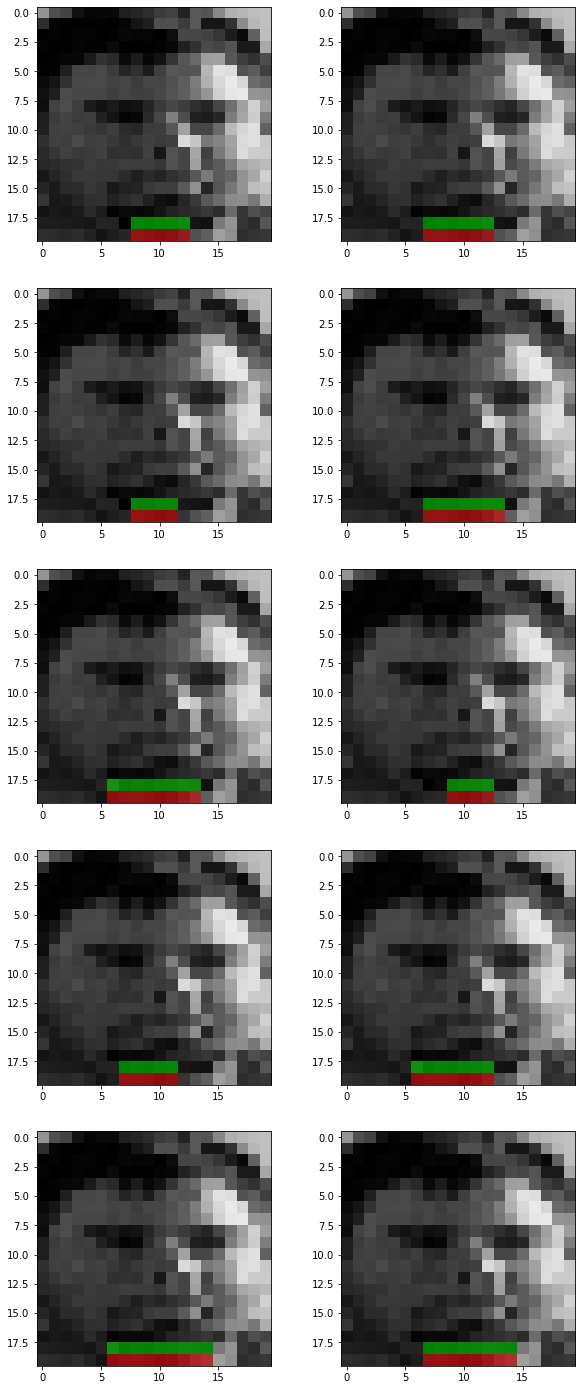

In [12]:
from PIL import Image
fig, ax = plt.subplots(5, 2, figsize=(10, 25))
ax = ax.flatten()
for i in range(k):
    ax[i].imshow(Image.open('./result/' + 'before_boosting_best_feature_{}.png'.format(i)))
plt.show()

In [17]:
@njit(parallel=True, fastmath=True)
def AdaBoost_update_classifier(Xtrain, ytrain, weight, feature_index):
    no_features = Xtrain.shape[1]
    polarity = 0
    threshold = 0
    feature = 0
    err = 0
    min_e = np.inf
    
    for i in feature_index:
        
        for j in range(Xtrain.shape[0]):
            y_pred = np.ones(Xtrain.shape[0])
            y_pred[Xtrain[:,i] < Xtrain[j,i]] = -1
            
            temp_err = np.sum(weight[y_pred != ytrain])
            temp_polarity = 1
            
            if temp_err > 0.5:
                temp_err = 1 - temp_err
                temp_polarity = -1

            if temp_err < min_e:
                polarity = temp_polarity
                threshold = Xtrain[j,i]
                feature = i
                err = temp_err
                min_e = temp_err      

    return polarity, threshold, feature, err


class AdaBoost():
    def __init__(self, no_iterations=100):
        self.no_iterations = no_iterations
        self.Classifiers = []
        
    def fit(self, X, y, feature_index=None):
        self.Xtrain = X
        self.ytrain = y
        no_features = self.Xtrain.shape[1]
        no_data = self.Xtrain.shape[0]
        signs = np.ones(no_features)
        thresholds = np.zeros(no_features)
        errors = np.ones(no_features) * 100
        self.weights = np.full(no_data, (1 / no_data))
        if feature_index is None:
            feature_index = np.arange(no_features)
                            
        for i in tqdm(range(0, self.no_iterations)):
            
            weakClassifier = WeakClassifier()
            
            polarity, threshold, feature, err = AdaBoost_update_classifier(self.Xtrain, self.ytrain, self.weights, feature_index)
            weakClassifier.polarity = polarity
            weakClassifier.threshold = threshold
            weakClassifier.feature = feature
            weakClassifier.err = err
            weakClassifier.alpha = 0.5 * np.log((1.0 - err) / err)
            
            pred = np.ones(no_data)
            index = (weakClassifier.polarity * self.Xtrain[:, weakClassifier.feature] < weakClassifier.polarity * weakClassifier.threshold)
            pred[index] = -1
            

            self.weights *= np.exp((-weakClassifier.alpha) * (self.ytrain * pred))
            self.weights /= np.sum(self.weights)

            self.Classifiers.append(weakClassifier)

            
    def predict(self, X):
        self.Xtest = X
        no_data = self.Xtest.shape[0]
        y_pred = np.zeros(no_data)
        for weakClassifier in self.Classifiers:
            pred = np.ones(no_data)
            index = (weakClassifier.polarity * self.Xtest[:, weakClassifier.feature] < weakClassifier.polarity * weakClassifier.threshold)
            pred[index] = -1
            y_pred += weakClassifier.alpha * pred
        y_pred = np.sign(y_pred).flatten()
        return y_pred

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:06<00:00,  1.50it/s]

The accuracy score is 0.835


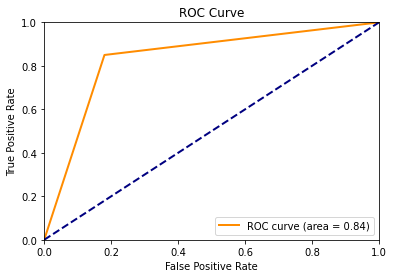

In [19]:
adaboost = AdaBoost(100)
adaboost.fit(X_train, y_train, feature_index)
y_pred = adaboost.predict(X_test)

print('The accuracy score is {}'.format(accuracy_score(y_test, y_pred)))

plot_roc_curve(y_test, y_pred)